# 📘 Notebook 07: Feature Selection

 
**Dataset:** 114,000 Spotify tracks with 21 audio features  

---

## 🎯 Notebook Objectives

This notebook performs systematic feature selection to identify the most predictive features for song popularity. The analysis uses **three complementary methods** to create optimized feature sets for modeling.

### Analysis Pipeline:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│  SECTION 1: Setup & Data Loading                                            │
│  └─► Load scaled training data from Notebook 06                            │
│                                                                             │
│  SECTION 2: Correlation Analysis                                            │
│  └─► Calculate Pearson correlation between features and popularity         │
│  └─► Identify features with strongest linear relationships                 │
│                                                                             │
│  SECTION 3: Multicollinearity Analysis                                      │
│  └─► Correlation heatmap to find redundant feature pairs                   │
│  └─► VIF (Variance Inflation Factor) to quantify multicollinearity         │
│                                                                             │
│  SECTION 4: Feature Set Creation                                            │
│  └─► Combine insights from all methods                                      │
│  └─► Create Full, Reduced, and Top feature sets                            │
│                                                                             │
│  SECTION 5: Save Outputs                                                    │
│  └─► Export feature sets and datasets for modeling                         │
└─────────────────────────────────────────────────────────────────────────────┘
```

---

## 📊 Why Feature Selection Matters

| Benefit | Description | Impact on This Project |
|---------|-------------|------------------------|
| **Model Performance** | Removes noisy features that confuse models | Particularly important given weak correlations (~0.13 max) |
| **Reduced Overfitting** | Simpler models generalize better | Critical for 114K sample dataset |
| **Computational Efficiency** | Fewer features = faster training | Enables thorough hyperparameter search |
| **Interpretability** | Easier to explain which factors drive popularity | Important for presentation |

---

## 🔧 Methods Used

| Method | What It Measures | Best For |
|--------|------------------|----------|
| **Pearson Correlation** | Linear relationship with target | Linear Regression, Ridge, Lasso |
| **VIF Analysis** | Redundancy between features | All models (removes multicollinearity) |
| **Combined Ranking** | Average of correlation & VIF ranks | Creating balanced feature sets |

---

## 📋 Outputs 

By the end of this notebook:
- ✅ Three feature sets were created: **Full** (24), **Reduced** (13), **Top** (10) : refer to data folder
- ✅ `feature_sets.json` with feature definitions and rankings
- ✅ Train/test CSVs for each feature set
- ✅ Clear rationale for feature selection decisions

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 1: Environment Setup and Data Loading

**Purpose:** Import required libraries and load the scaled training data from Notebook 06.

**Key Decision:** We perform feature selection on **training data only** to prevent data leakage. The test set remains untouched until final model evaluation.

In [ ]:

import pandas as pd                    # DataFrame operations for tabular data
import numpy as np                     # Numerical computations and array operations

# VISUALIZATION

import matplotlib.pyplot as plt        # Base plotting library
import matplotlib.colors as mcolors   # Custom color maps for heatmaps
import seaborn as sns                  # Statistical visualizations (heatmaps)

 
# SCIKIT-LEARN: FEATURE SELECTION TOOLS
 
from sklearn.ensemble import RandomForestRegressor     # Tree-based feature importance
from sklearn.feature_selection import VarianceThreshold  # Remove low-variance features
from sklearn.feature_selection import SelectKBest, f_regression  # Univariate selection

 
# STATISTICAL ANALYSIS
 
from scipy import stats                # Statistical functions (p-values, tests)

# VIF (Variance Inflation Factor) for multicollinearity detection
# VIF quantifies how much a feature's variance is inflated due to correlation
# with other features. High VIF (>10) indicates problematic multicollinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor

 
# FILE OPERATIONS
 
import json                            # Save feature sets as JSON
import os                              # File path operations

 
# CONFIGURATION
 
import warnings
warnings.filterwarnings('ignore')      # Suppress convergence warnings

# Pandas display settings for better output readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap output

print(" All libraries imported successfully")
print("\nKey Libraries:")
print(f"   - pandas {pd.__version__}")
print(f"   - numpy {np.__version__}")
print(f"   - scikit-learn (RandomForest, SelectKBest)")
print(f"   - statsmodels (VIF calculation)")

✅ All libraries imported successfully

📦 Key Libraries:
   - pandas 2.3.3
   - numpy 2.3.4
   - scikit-learn (RandomForest, SelectKBest)
   - statsmodels (VIF calculation)


In [ ]:

# Load the scaled training and test data from Notebook 06 (Scaling).
#
# DATA LEAKAGE PREVENTION:
# - Feature selection is performed ONLY on training data
# - Test data is loaded but NOT used for selection decisions
# - This ensures unbiased evaluation in later notebooks
#
# FILE STRUCTURE:
# ../data/
#   ├── X_train_scaled.csv  (features, scaled)
#   ├── X_test_scaled.csv   (features, scaled)
#   ├── y_train.csv         (target: popularity)
#   └── y_test.csv          (target: popularity)


# LOAD TRAINING DATA

# X_train contains scaled features (numerical features standardized)
# y_train contains the target variable (popularity score 0-100)

X_train = pd.read_csv('../data/X_train_scaled.csv')

# .squeeze() converts single-column DataFrame to Series for easier manipulation
y_train = pd.read_csv('../data/y_train.csv').squeeze()


# LOAD TEST DATA (for later export, NOT for selection decisions)

X_test = pd.read_csv('../data/X_test_scaled.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()


# VERIFY DATA SHAPES

print("=" * 60)
print("DATA LOADED SUCCESSFULLY")
print("=" * 60)
print(f"\nTraining set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set:     X={X_test.shape}, y={y_test.shape}")
print(f"\nFeatures ({len(X_train.columns)} total):")

# Display features in a readable format (4 columns)
features = X_train.columns.tolist()
for i in range(0, len(features), 4):
    row = features[i:i+4]
    print(f"   {', '.join(row)}")

DATA LOADED SUCCESSFULLY

📊 Training set: X=(71792, 24), y=(71792,)
📊 Test set:     X=(17948, 24), y=(17948,)

📋 Features (24 total):
   duration_ms, explicit, danceability, energy
   key, loudness, mode, speechiness
   acousticness, instrumentalness, liveness, valence
   tempo, time_signature, duration_min, energy_x_danceability
   loudness_x_energy, valence_x_danceability, is_instrumental, has_vocals
   is_speech_heavy, tempo_log, duration_category, track_genre


In [ ]:

# CELL 1.3: LOAD FEATURE CONFIGURATION

# Load the feature configuration saved in Notebook 06 (Scaling).
# This tells us which features were:
#   - Scaled using StandardScaler (continuous numerical features)
#   - Left unchanged (binary, bounded 0-1, ordinal features)
#
# This information helps interpret correlation values correctly:
#   - Scaled features: correlation is scale-independent
#   - Binary features: correlation reflects group differences


with open('../models/feature_config.json', 'r') as f:
    feature_config = json.load(f)

print("=" * 60)
print("FEATURE CONFIGURATION (from Notebook 06)")
print("=" * 60)
print(f"\n🎯 Target variable: {feature_config['target']}")
print(f"\n📊 Feature categories:")
print(f"   • Scaled (StandardScaler):  {len(feature_config['features_scaled'])} features")
print(f"   • Binary (0/1):             {len(feature_config['features_binary'])} features")
print(f"   • Bounded (0-1 range):      {len(feature_config['features_bounded'])} features")
print(f"   • Ordinal (categorical):    {len(feature_config['features_ordinal'])} features")

# Display scaled features (these are the ones where scaling matters)
print(f"\n🔧 Scaled features: {feature_config['features_scaled']}")

FEATURE CONFIGURATION (from Notebook 06)

🎯 Target variable: popularity

📊 Feature categories:
   • Scaled (StandardScaler):  9 features
   • Binary (0/1):             5 features
   • Bounded (0-1 range):      7 features
   • Ordinal (categorical):    3 features

🔧 Scaled features: ['duration_ms', 'duration_min', 'loudness', 'tempo', 'tempo_log', 'track_genre', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability']


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 2: Correlation Analysis with Target

**Purpose:** Calculate Pearson correlation between each feature and the target variable (popularity).

**Why Pearson Correlation?**
- Measures **linear** relationship strength (-1 to +1)
- Directly relevant for Linear Regression, Ridge, and Lasso models
- Easy to interpret: positive = higher feature → higher popularity

**Interpretation Guide:**
| Correlation | Strength | Implication |
|-------------|----------|-------------|
| |r| ≥ 0.10 | Strong (for this dataset) | Useful predictor |
| 0.05 ≤ |r| < 0.10 | Moderate | May contribute |
| |r| < 0.05 | Weak | Limited predictive value |

**Note:** From EDA (Notebook 02-03), we found that audio features have surprisingly weak correlations with popularity (strongest ~0.13 for instrumentalness). This is a key insight about the prediction challenge.

In [ ]:

# CELL 2.1: CALCULATE CORRELATIONS WITH TARGET

# Calculate Pearson correlation coefficient between each feature and popularity.
#
# PEARSON CORRELATION:
# - Measures LINEAR relationship between two variables
# - Range: -1 (perfect negative) to +1 (perfect positive)
# - 0 = no linear relationship (but non-linear may exist!)
#
# METHODOLOGY:
# 1. Combine X_train and y_train into single DataFrame
# 2. Calculate full correlation matrix
# 3. Extract only correlations with 'popularity' column
# 4. Sort by absolute value (strength regardless of direction)


# STEP 1: Combine features and target for correlation calculation
   
train_data = X_train.copy()           # Don't modify original
train_data['popularity'] = y_train.values  # Add target column

   
# STEP 2: Calculate correlations with target
   
# .corr() computes pairwise Pearson correlation
#  extract only the 'popularity' column and drop self-correlation
target_correlations = train_data.corr()['popularity'].drop('popularity')

   
# STEP 3: Sort by absolute correlation (strongest relationships first)
   
target_corr_sorted = target_correlations.abs().sort_values(ascending=False)

   
# STEP 4: Display results with visual indicators
   
print("=" * 60)
print("FEATURE CORRELATIONS WITH POPULARITY")
print("=" * 60)
print("\nRanked by absolute correlation strength:")
print("(Positive = higher value → higher popularity)")
print("-" * 60)

for feat in target_corr_sorted.index:
    corr_val = target_correlations[feat]   # Actual value (with sign)
    abs_corr = abs(corr_val)               # Absolute value for categorization
    
    # Categorize strength based on our thresholds
    # Note: These thresholds are RELATIVE to this dataset's characteristics
    if abs_corr >= 0.1:
        strength = "🟢 Strong"    # Best predictors in this dataset
    elif abs_corr >= 0.05:
        strength = "Moderate"  # May contribute to predictions
    else:
        strength = "Weak"      # Limited predictive value
    
    # Format: feature name (left-aligned), correlation (signed), strength
    print(f"  {feat:<30} {corr_val:+.4f}  {strength}")

FEATURE CORRELATIONS WITH POPULARITY

Ranked by absolute correlation strength:
(Positive = higher value → higher popularity)
------------------------------------------------------------
  track_genre                    +0.5720  🟢 Strong
  instrumentalness               -0.1267  🟢 Strong
  has_vocals                     +0.1234  🟢 Strong
  is_instrumental                -0.1206  🟢 Strong
  loudness                       +0.0874  🟡 Moderate
  danceability                   +0.0637  🟡 Moderate
  loudness_x_energy              +0.0576  🟡 Moderate
  explicit                       +0.0557  🟡 Moderate
  speechiness                    -0.0449  🔴 Weak
  acousticness                   -0.0408  🔴 Weak
  time_signature                 +0.0378  🔴 Weak
  energy_x_danceability          +0.0376  🔴 Weak
  duration_min                   -0.0224  🔴 Weak
  duration_ms                    -0.0224  🔴 Weak
  liveness                       -0.0183  🔴 Weak
  mode                           -0.0150  🔴 Weak
  vale

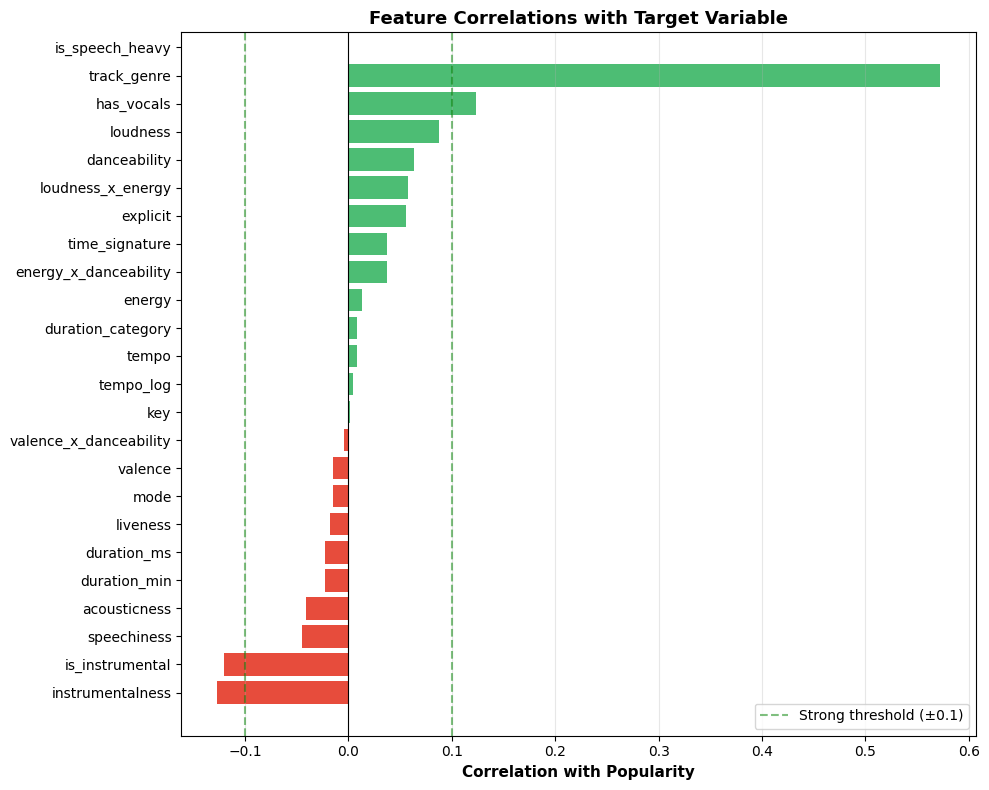


📌 KEY INSIGHT:
   All audio features have weak correlations with popularity (< 0.15).
   This suggests popularity is influenced by factors beyond audio characteristics.


In [ ]:
# =============================================================================
# CELL 2.2: VISUALIZE TARGET CORRELATIONS
# =============================================================================
# Create a horizontal bar chart showing correlation strength with popularity.
#
# VISUALIZATION DESIGN:
# - Horizontal bars allow easy reading of feature names
# - Color indicates direction: green (positive) vs red (negative)
# - Dashed lines mark the "strong" correlation threshold (±0.1)
# - Features sorted by correlation value (not absolute)
#
# This visualization will be used in the presentation to show
# which features have the strongest relationship with popularity.
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# SET UP FIGURE
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))

# Sort by actual correlation value (negative at bottom, positive at top)
corr_sorted = target_correlations.sort_values()

# ─────────────────────────────────────────────────────────────────────────────
# COLOR CODING: Positive (green) vs Negative (red) correlations
# ─────────────────────────────────────────────────────────────────────────────
# Green (#4dbd74): Higher feature value → Higher popularity
# Red (#e74c3c): Higher feature value → Lower popularity
colors = ['#535353' if x < 0 else '#1DB954' for x in corr_sorted.values]

# ─────────────────────────────────────────────────────────────────────────────
# CREATE HORIZONTAL BAR CHART
# ─────────────────────────────────────────────────────────────────────────────
bars = ax.barh(corr_sorted.index, corr_sorted.values, color=colors)

# Add vertical line at 0 (no correlation)
ax.axvline(x=0, color='black', linewidth=0.8)

# Add threshold lines at ±0.1 (our "strong" threshold for this dataset)
ax.axvline(x=0.1, color='green', linestyle='--', alpha=0.5, 
           label='Strong threshold (±0.1)')
ax.axvline(x=-0.1, color='green', linestyle='--', alpha=0.5)

# ─────────────────────────────────────────────────────────────────────────────
# FORMATTING
# ─────────────────────────────────────────────────────────────────────────────
ax.set_xlabel('Correlation with Popularity', fontsize=11, fontweight='bold')
ax.set_title('Feature Correlations with Target Variable', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# KEY INSIGHT (for presentation)
# ─────────────────────────────────────────────────────────────────────────────
print("\n📌 KEY INSIGHT:")
print("   All audio features have weak correlations with popularity (< 0.15).")
print("   This suggests popularity is influenced by factors beyond audio characteristics.")

In [ ]:
# =============================================================================
# CELL 2.3: CORRELATION INSIGHTS SUMMARY
# =============================================================================
# Categorize features into groups based on correlation strength.
# This summary helps decide which features to prioritize.
#
# CATEGORIZATION LOGIC:
# - Strong positive (≥ 0.1): Keep - best linear predictors
# - Strong negative (≤ -0.1): Keep - inversely related to popularity
# - Moderate (0.05-0.1): Keep - may add predictive value
# - Weak (< 0.05): Consider for removal (but may help non-linear models)
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# CATEGORIZE FEATURES BY CORRELATION STRENGTH
# ─────────────────────────────────────────────────────────────────────────────
strong_positive = target_correlations[target_correlations >= 0.1].index.tolist()
strong_negative = target_correlations[target_correlations <= -0.1].index.tolist()
moderate = target_correlations[
    (target_correlations.abs() >= 0.05) & 
    (target_correlations.abs() < 0.1)
].index.tolist()
weak = target_correlations[target_correlations.abs() < 0.05].index.tolist()

# ─────────────────────────────────────────────────────────────────────────────
# DISPLAY SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("CORRELATION SUMMARY")
print("=" * 60)

print(f"\n🟢 Strong Positive (≥ 0.1): {len(strong_positive)} features")
print("   (Higher value → Higher popularity)")
for f in strong_positive:
    print(f"   • {f}: {target_correlations[f]:+.4f}")

print(f"\n⚫ Strong Negative (≤ -0.1): {len(strong_negative)} features")
print("   (Higher value → Lower popularity)")
for f in strong_negative:
    print(f"   • {f}: {target_correlations[f]:+.4f}")

print(f"\n⬜ Moderate (0.05-0.1): {len(moderate)} features")
for f in moderate:
    print(f"   • {f}: {target_correlations[f]:+.4f}")

print(f"\n⚪ Weak (< 0.05): {len(weak)} features")
print(f"   {weak}")

# ─────────────────────────────────────────────────────────────────────────────
# RECOMMENDATION
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("RECOMMENDATION")
print("=" * 60)
print("\n• Strong/Moderate features: Prioritize for linear models")
print("• Weak features: May still help tree-based models (Random Forest)")
print("• Next step: Check multicollinearity before final selection")

CORRELATION SUMMARY

🟢 Strong Positive (≥ 0.1): 2 features
   (Higher value → Higher popularity)
   • has_vocals: +0.1234
   • track_genre: +0.5720

🔴 Strong Negative (≤ -0.1): 2 features
   (Higher value → Lower popularity)
   • instrumentalness: -0.1267
   • is_instrumental: -0.1206

🟡 Moderate (0.05-0.1): 4 features
   • explicit: +0.0557
   • danceability: +0.0637
   • loudness: +0.0874
   • loudness_x_energy: +0.0576

⚪ Weak (< 0.05): 15 features
   ['duration_ms', 'energy', 'key', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'valence_x_danceability', 'tempo_log', 'duration_category']

RECOMMENDATION

• Strong/Moderate features: Prioritize for linear models
• Weak features: May still help tree-based models (Random Forest)
• Next step: Check multicollinearity before final selection


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 3: Multicollinearity Analysis

**Purpose:** Identify redundant features that are highly correlated with each other.

**Why It Matters:**
- **Linear Regression:** Multicollinearity makes coefficients unstable and hard to interpret
- **All Models:** Redundant features add computational cost without improving predictions
- **Feature Engineering:** Some of our engineered features (e.g., `tempo_log`, `duration_min`) are derived from original features

**Methods Used:**

| Method | What It Detects | Threshold |
|--------|-----------------|----------|
| **Correlation Heatmap** | Pairwise feature correlations | \|r\| > 0.7 |
| **VIF (Variance Inflation Factor)** | How much a feature's variance is inflated by other features | VIF > 10 |

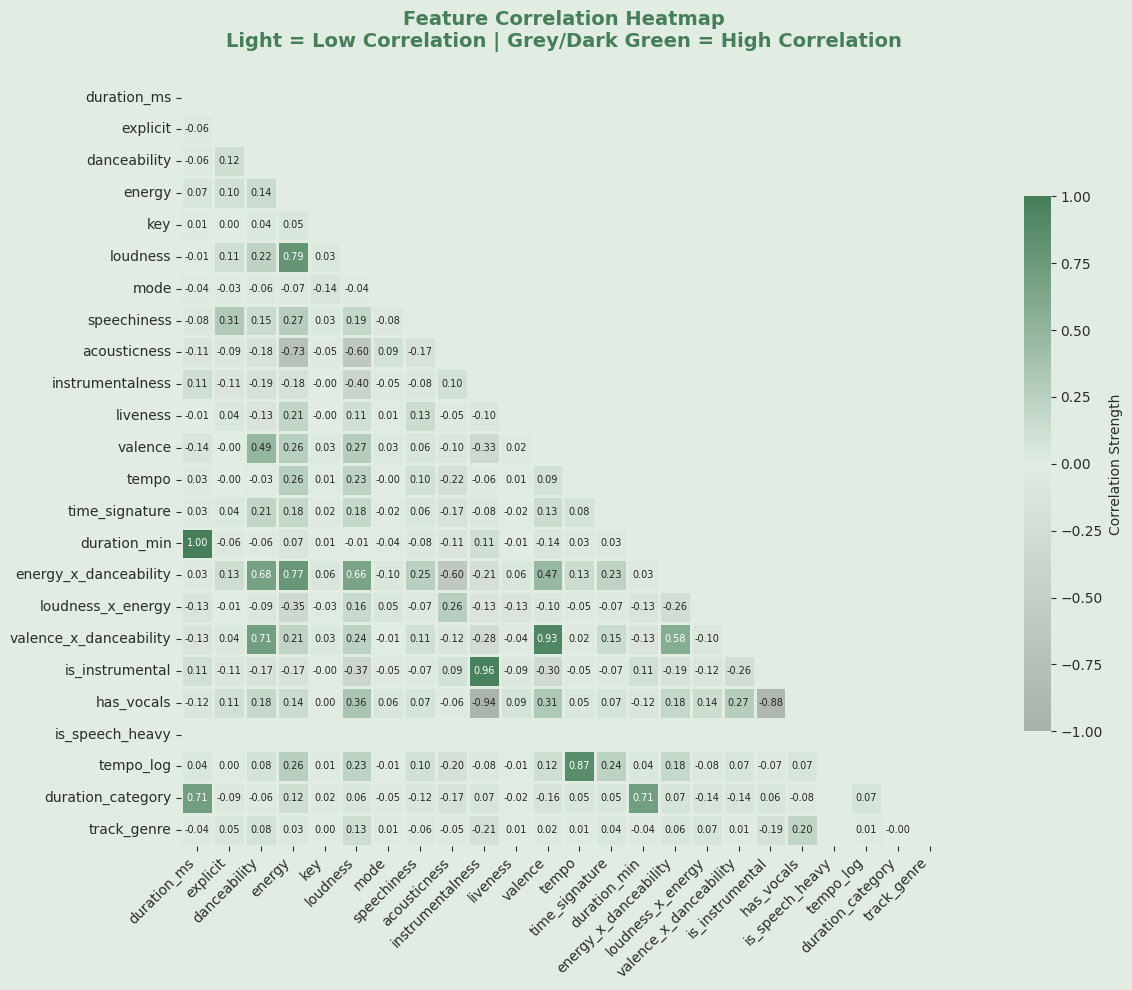

In [ ]:
   
# CELL 3.1: FEATURE CORRELATION HEATMAP
   
# Create a correlation heatmap to visualize pairwise feature correlations.
#
# DESIGN DECISIONS:
# - Use lower triangle only (upper triangle is redundant)
# - Custom color palette matching project theme (green-based)
# - Diverging colormap: grey (negative) → light green (neutral) → dark green (positive)
# - Annotations show correlation values for reference
#
# INTERPRETATION:
# - Dark green cells: Strong positive correlation (features move together)
# - Grey cells: Strong negative correlation (features move opposite)
# - Light green cells: Little correlation (independent features)
   

   
# DEFINE COLOR PALETTE (consistent with project theme)
   
BG = "#e1ece3"       # Very light green (background, neutral)
PRIMARY = "#62d089"  # Medium green (moderate values)
EMPHASIS = "#457e59" # Dark green (high positive correlation)
GRID = "#a8b2a8"     # Grey (high negative correlation)

   
# SET PLOT STYLE
   
plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "axes.edgecolor": GRID,
    "axes.labelcolor": "#2b2b2b",
    "xtick.color": "#2b2b2b",
    "ytick.color": "#2b2b2b",
    "grid.color": GRID,
    "grid.alpha": 0.2,
    "axes.grid": False,  # Heatmaps look cleaner without background grid
    "font.size": 10
})

   
# CREATE CUSTOM COLORMAP
   
# Diverging: Grey (negative) → Light Green (neutral) → Dark Green (positive)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "spotify_diverging", [GRID, BG, EMPHASIS]
)

   
# DEFINE FULL FEATURE LIST (all 24 features)
   
features_full = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature', 'duration_min', 
    'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability',
    'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log',
    'duration_category', 'track_genre'
]

   
# CALCULATE PAIRWISE CORRELATIONS
   
feature_corr = X_train[features_full].corr()

   
# CREATE HEATMAP
   
plt.figure(figsize=(16, 10))

# Create mask for upper triangle (avoid showing redundant info)
mask = np.triu(np.ones_like(feature_corr, dtype=bool))

sns.heatmap(
    feature_corr,
    mask=mask,
    annot=True,          # Show correlation values
    fmt='.2f',           # Two decimal places
    cmap=custom_cmap,
    center=0,            # Zero = neutral color (light green)
    vmin=-1, vmax=1,     # Fixed scale for comparison
    square=True,         # Square cells
    linewidths=1.0,
    linecolor=BG,
    cbar_kws={'shrink': 0.7, 'label': 'Correlation Strength'},
    annot_kws={'size': 7}
)

plt.title('Feature Correlation Heatmap\nLight = Low Correlation | Grey/Dark Green = High Correlation', 
          fontsize=14, fontweight='bold', pad=25, color=EMPHASIS)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
"The Problem: Usually, loud songs are high energy, and quiet songs are low energy. If two features move almost exactly the same way, they are "highly correlated."


This code below scans through all possible feature pairs in our dataset to find those that are too similar to each other, using a correlation threshold of 0.7. The nested loop compares each feature with every other feature, but only checks the upper triangle of the correlation matrix to avoid counting the same pair twice. When two features have a correlation above 0.7 (either positive or negative), they essentially carry redundant information, which causes problems for linear regression models by making coefficients unstable and unreliable. By identifying these highly correlated pairs, we can make informed decisions about which features to remove, keeping the one that has a stronger relationship with our target variable (popularity) while discarding its redundant partner. This reduces multicollinearity in our dataset and leads to more stable, interpretable models.


If two features are more than 70% similar, the code says, "These two are basically twins." We only need one twin to tell the story of the music.

In [8]:
# =============================================================================
# CELL 3.2: IDENTIFY HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
# Find feature pairs with |correlation| > 0.7 (threshold for multicollinearity).
#
# WHY 0.7 THRESHOLD?
# - Below 0.7: Generally acceptable correlation
# - 0.7-0.9: Moderate multicollinearity, may affect linear models
# - Above 0.9: Severe multicollinearity, should address
#
# EXPECTED FINDINGS:
# - tempo vs tempo_log (log transform of same variable)
# - duration_ms vs duration_min (same variable, different units)
# - energy vs loudness (physically related audio properties)
# =============================================================================

threshold = 0.7  # Correlation threshold for multicollinearity concern

# ─────────────────────────────────────────────────────────────────────────────
# FIND ALL PAIRS EXCEEDING THRESHOLD
# ─────────────────────────────────────────────────────────────────────────────
# Only check upper triangle to avoid duplicates and self-correlations
high_corr_pairs = []

for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):  # j > i avoids duplicates
        corr_val = feature_corr.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'feature_1': feature_corr.columns[i],
                'feature_2': feature_corr.columns[j],
                'correlation': corr_val
            })

# ─────────────────────────────────────────────────────────────────────────────
# DISPLAY RESULTS
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print(f"HIGHLY CORRELATED FEATURE PAIRS (|r| > {threshold})")
print("=" * 60)

if high_corr_pairs:
    # Sort by absolute correlation (strongest first)
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(
        'correlation', key=abs, ascending=False
    )
    print("\n" + high_corr_df.to_string(index=False))
    
    print("\n" + "-" * 60)
    print("RECOMMENDATION:")
    print("Consider removing one feature from each highly correlated pair.")
    print("Keep the feature with higher correlation to target.")
else:
    print("\n✅ No highly correlated feature pairs found!")

HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)

       feature_1              feature_2  correlation
     duration_ms           duration_min     1.000000
instrumentalness        is_instrumental     0.962321
instrumentalness             has_vocals    -0.944137
         valence valence_x_danceability     0.928528
 is_instrumental             has_vocals    -0.883197
           tempo              tempo_log     0.869366
          energy               loudness     0.786928
          energy  energy_x_danceability     0.773430
          energy           acousticness    -0.732260
     duration_ms      duration_category     0.714647
    duration_min      duration_category     0.714647
    danceability valence_x_danceability     0.708398

------------------------------------------------------------
RECOMMENDATION:
Consider removing one feature from each highly correlated pair.
Keep the feature with higher correlation to target.


---
While the previous correlation check looked at pairs (Is Feature A like Feature B?), VIF looks at the whole group. It checks if one feature is just a "copycat" of a combination of several other features.

The Problem: The "Copycat" Effect
here we are predicting a song's popularity.

Feature 1: Volume (Loudness)

Feature 2: Lack of Vocals (Instrumentalness)

Feature 3: Acousticness

Whatif Acousticness isn't just similar to one other thing; instead, it is perfectly explained by a mix of Low Volume + High Instrumentalness.

If I keep all three, the model gets "information overload." It sees the same data repeated in different forms, which makes the model's math unstable and its predictions unreliable.

In [9]:
# =============================================================================
# CELL 3.3: VARIANCE INFLATION FACTOR (VIF) CALCULATION
# =============================================================================
# VIF measures how much a feature's variance is inflated due to correlation
# with OTHER features. Unlike pairwise correlation, VIF considers ALL features.
#
# FORMULA: VIF_i = 1 / (1 - R²_i)
# Where R²_i is the R-squared from regressing feature i on all other features.
#
# INTERPRETATION:
# ┌──────────┬────────────────────────────────────────────────────────────────┐
# │ VIF      │ Interpretation                                                 │
# ├──────────┼────────────────────────────────────────────────────────────────┤
# │ 1        │ No correlation with other features (ideal)                     │
# │ 1-5      │ Low to moderate correlation (acceptable)                       │
# │ 5-10     │ High correlation (concerning, may affect coefficients)         │
# │ > 10     │ Very high correlation (problematic, strongly consider removal) │
# └──────────┴────────────────────────────────────────────────────────────────┘
#
# WHY VIF OVER CORRELATION MATRIX?
# - Correlation matrix only shows pairwise relationships
# - VIF captures multiway relationships (A correlated with B+C combined)
# =============================================================================

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor for each feature.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix (should not include target variable)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['feature', 'VIF'], sorted by VIF descending
    """
    vif_data = []
    
    for i, col in enumerate(X.columns):
        try:
            # variance_inflation_factor requires numpy array and column index
            vif = variance_inflation_factor(X.values, i)
            vif_data.append({'feature': col, 'VIF': vif})
        except:
            # Handle edge cases (constant features, singular matrix)
            vif_data.append({'feature': col, 'VIF': np.nan})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

# ─────────────────────────────────────────────────────────────────────────────
# CALCULATE VIF FOR ALL FEATURES
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 60)
print("\nCalculating VIF for all features...")
print("(This may take a few seconds)\n")

vif_df = calculate_vif(X_train)

# ─────────────────────────────────────────────────────────────────────────────
# DISPLAY VIF VALUES WITH STATUS INDICATORS
# ─────────────────────────────────────────────────────────────────────────────
print("VIF Values (sorted by highest):")
print("-" * 50)

for _, row in vif_df.iterrows():
    vif_val = row['VIF']
    feat = row['feature']
    
    # Status based on VIF threshold
    if vif_val > 10:
        status = "🔴 REMOVE"   # Severe multicollinearity
    elif vif_val > 5:
        status = "🟡 WATCH"    # Moderate multicollinearity
    else:
        status = "🟢 OK"       # Acceptable
    
    print(f"  {feat:<30} VIF: {vif_val:>8.2f}  {status}")

# ─────────────────────────────────────────────────────────────────────────────
# SUMMARY STATISTICS
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "-" * 50)
print(f"Features with VIF > 10 (REMOVE): {len(vif_df[vif_df['VIF'] > 10])}")
print(f"Features with VIF 5-10 (WATCH):  {len(vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)])}")
print(f"Features with VIF < 5 (OK):      {len(vif_df[vif_df['VIF'] <= 5])}")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Calculating VIF for all features...
(This may take a few seconds)

VIF Values (sorted by highest):
--------------------------------------------------
  duration_ms                    VIF:      inf  🔴 REMOVE
  duration_min                   VIF:      inf  🔴 REMOVE
  energy                         VIF:    92.68  🔴 REMOVE
  time_signature                 VIF:    79.47  🔴 REMOVE
  valence                        VIF:    58.77  🔴 REMOVE
  has_vocals                     VIF:    40.63  🔴 REMOVE
  instrumentalness               VIF:    38.53  🔴 REMOVE
  danceability                   VIF:    38.35  🔴 REMOVE
  valence_x_danceability         VIF:    20.25  🔴 REMOVE
  is_instrumental                VIF:    18.19  🔴 REMOVE
  energy_x_danceability          VIF:    11.09  🔴 REMOVE
  duration_category              VIF:     9.85  🟡 WATCH
  loudness                       VIF:     7.15  🟡 WATCH
  tempo_log                      VIF:     4.59  🟢 OK
  tempo         

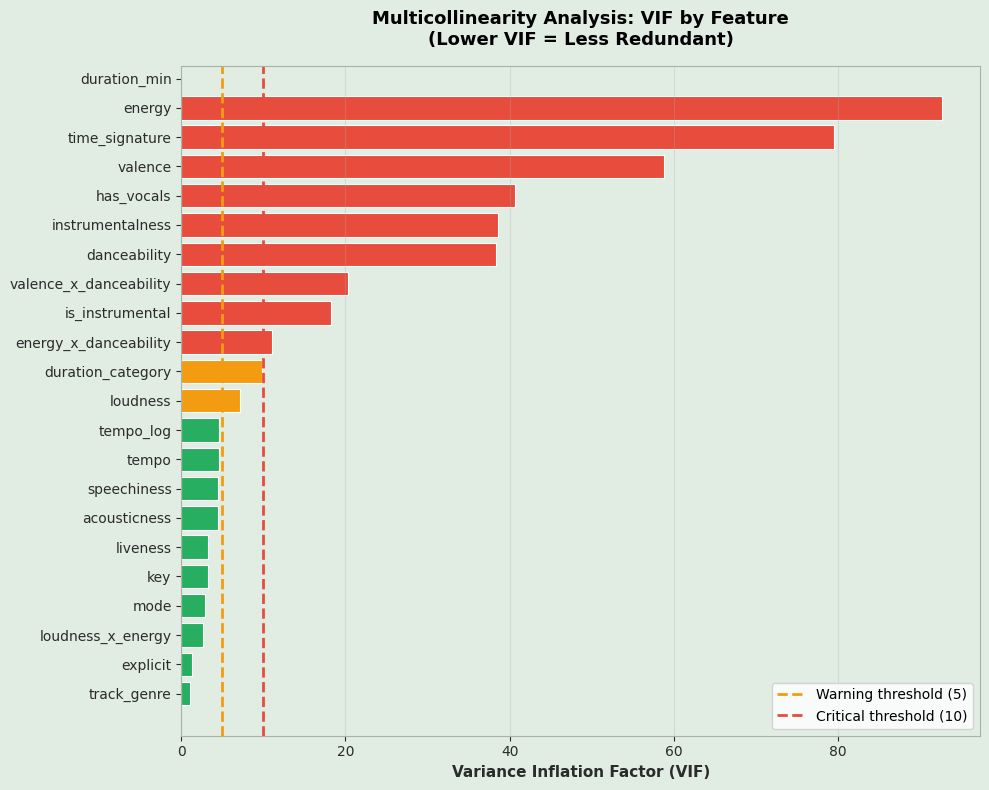


📌 KEY INSIGHT:
   Features with VIF > 10: ['duration_ms', 'duration_min', 'energy', 'time_signature', 'valence', 'has_vocals', 'instrumentalness', 'danceability', 'valence_x_danceability', 'is_instrumental', 'energy_x_danceability']
   These should be removed to reduce multicollinearity.


In [10]:
# =============================================================================
# CELL 3.4: VISUALIZE VIF VALUES
# =============================================================================
# Create a horizontal bar chart showing VIF for each feature.
# Color-coded by severity: green (OK) → orange (warning) → red (critical)
#
# This visualization clearly shows which features have multicollinearity
# issues and should be considered for removal.
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# SET UP FIGURE
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))

# Sort by VIF (ascending so highest are at top of horizontal bar chart)
vif_sorted = vif_df.sort_values('VIF', ascending=True)

# ─────────────────────────────────────────────────────────────────────────────
# COLOR CODING BY VIF THRESHOLD
# ─────────────────────────────────────────────────────────────────────────────
# Green: VIF < 5 (healthy, low multicollinearity)
# Orange: VIF 5-10 (warning, moderate multicollinearity)  
# Red: VIF > 10 (critical, severe multicollinearity)
colors = []
for vif in vif_sorted['VIF']:
    if vif > 10:
        colors.append('#e74c3c')  # Red - Critical
    elif vif > 5:
        colors.append('#f39c12')  # Orange - Warning
    else:
        colors.append('#27ae60')  # Green - OK

# ─────────────────────────────────────────────────────────────────────────────
# CREATE HORIZONTAL BAR CHART
# ─────────────────────────────────────────────────────────────────────────────
ax.barh(vif_sorted['feature'], vif_sorted['VIF'], color=colors, 
        edgecolor='white', linewidth=0.8)

# Add threshold lines
ax.axvline(x=5, color='#f39c12', linestyle='--', linewidth=2, 
           label='Warning threshold (5)')
ax.axvline(x=10, color='#e74c3c', linestyle='--', linewidth=2, 
           label='Critical threshold (10)')

# ─────────────────────────────────────────────────────────────────────────────
# FORMATTING
# ─────────────────────────────────────────────────────────────────────────────
ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=11, fontweight='bold')
ax.set_title('Multicollinearity Analysis: VIF by Feature\n(Lower VIF = Less Redundant)', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='lower right', frameon=True, facecolor='white')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# KEY INSIGHT
# ─────────────────────────────────────────────────────────────────────────────
print("\n📌 KEY INSIGHT:")
high_vif_features = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
print(f"   Features with VIF > 10: {high_vif_features}")
print("   These should be removed to reduce multicollinearity.")

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 4: Feature Set Creation

**Purpose:** Combine insights from correlation analysis and VIF to create optimized feature sets.

**Feature Set Strategy:**

| Set | Criteria | Purpose |
|-----|----------|----------|
| **Full** | All 24 features | Baseline comparison |
| **Reduced** | Remove VIF > 10 features | Address multicollinearity |
| **Top** | VIF < 5 only | Most stable, independent features |

**Why Three Sets?**
1. Compare model performance across feature sets
2. Determine if reducing features improves or hurts prediction
3. Balance between model complexity and performance

In [11]:
# =============================================================================
# CELL 4.1: CREATE FEATURE SETS
# =============================================================================
# Based on correlation and VIF analysis, create three feature sets:
#
# 1. FULL: All 24 features (baseline for comparison)
# 2. REDUCED: Remove features with VIF > 10 (address multicollinearity)
# 3. TOP: Only features with VIF < 5 (most independent features)
#
# SELECTION LOGIC:
# - For highly correlated pairs, keep feature with higher target correlation
# - For high VIF features, remove to improve linear model stability
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# STEP 1: Define full feature set (all 24 features)
# ─────────────────────────────────────────────────────────────────────────────
features_full = list(feature_corr.columns)

# ─────────────────────────────────────────────────────────────────────────────
# STEP 2: Create VIF lookup dictionary for easy access
# ─────────────────────────────────────────────────────────────────────────────
vif_dict = dict(zip(vif_df['feature'], vif_df['VIF']))

# ─────────────────────────────────────────────────────────────────────────────
# STEP 3: Identify features to remove
# ─────────────────────────────────────────────────────────────────────────────

# 3a. Perfect duplicates (correlation > 0.99)
# For these pairs, keep one and remove the other (choose based on VIF)
perfect_corr_to_remove = []
for pair in high_corr_pairs:
    if abs(pair['correlation']) > 0.99:
        f1, f2 = pair['feature_1'], pair['feature_2']
        # Remove the one with higher VIF (more redundant)
        remove = f1 if vif_dict.get(f1, 0) > vif_dict.get(f2, 0) else f2
        if remove not in perfect_corr_to_remove:
            perfect_corr_to_remove.append(remove)

# 3b. High VIF features (VIF > 10)
# These have severe multicollinearity, affecting linear model coefficients
high_vif_to_remove = [
    feature for feature, vif in vif_dict.items() 
    if vif > 10 and feature not in perfect_corr_to_remove
]

# 3c. Combine all features to remove
features_to_remove = list(set(perfect_corr_to_remove + high_vif_to_remove))

# ─────────────────────────────────────────────────────────────────────────────
# STEP 4: Create reduced and top feature sets
# ─────────────────────────────────────────────────────────────────────────────

# REDUCED: Remove high VIF features
features_reduced = [f for f in features_full if f not in features_to_remove]

# TOP: Only features with VIF < 5 (most stable, independent features)
features_top = [f for f in features_reduced if vif_dict.get(f, 999) < 5]

# ─────────────────────────────────────────────────────────────────────────────
# STEP 5: Display summary
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("FEATURE SETS CREATED")
print("=" * 60)
print(f"\n📋 FULL SET:     {len(features_full)} features (baseline)")
print(f"📉 REDUCED SET:  {len(features_reduced)} features (VIF > 10 removed)")
print(f"🌟 TOP SET:      {len(features_top)} features (VIF < 5 only)")
print(f"\n🚫 REMOVED:      {len(features_to_remove)} features")
print(f"   {features_to_remove}")

FEATURE SETS CREATED

📋 FULL SET:     24 features (baseline)
📉 REDUCED SET:  13 features (VIF > 10 removed)
🌟 TOP SET:      10 features (VIF < 5 only)

🚫 REMOVED:      11 features
   ['energy_x_danceability', 'energy', 'is_instrumental', 'danceability', 'has_vocals', 'duration_ms', 'instrumentalness', 'duration_min', 'time_signature', 'valence', 'valence_x_danceability']


In [12]:
# =============================================================================
# CELL 4.2: DISPLAY FEATURE LISTS
# =============================================================================
# Display the contents of each feature set for documentation.
# These lists will be saved to JSON for use in modeling notebooks.
# =============================================================================

print("=" * 60)
print("FEATURE SET CONTENTS")
print("=" * 60)

print("\n--- FULL FEATURE SET (24 features) ---")
print("Purpose: Baseline comparison, tests if all features add value")
print(features_full)

print(f"\n--- REDUCED FEATURE SET ({len(features_reduced)} features) ---")
print("Purpose: Address multicollinearity for linear models")
print(features_reduced)

print(f"\n--- TOP FEATURE SET ({len(features_top)} features) ---")
print("Purpose: Most independent features, minimal redundancy")
print(features_top)

print(f"\n--- REMOVED FEATURES ({len(features_to_remove)} features) ---")
print("Reason: High VIF (> 10) indicating severe multicollinearity")
print(features_to_remove)

FEATURE SET CONTENTS

--- FULL FEATURE SET (24 features) ---
Purpose: Baseline comparison, tests if all features add value
['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']

--- REDUCED FEATURE SET (13 features) ---
Purpose: Address multicollinearity for linear models
['explicit', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'tempo', 'loudness_x_energy', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']

--- TOP FEATURE SET (10 features) ---
Purpose: Most independent features, minimal redundancy
['explicit', 'key', 'mode', 'speechiness', 'acousticness', 'liveness', 'tempo', 'loudness_x_energy', 'tempo_log', 'track_genre']

--- R

In [13]:
# =============================================================================
# CELL 4.3: CREATE FEATURE RANKINGS
# =============================================================================
# Create a combined ranking using correlation and VIF metrics.
# This provides a single score for each feature's importance.
#
# RANKING METHODOLOGY:
# 1. Correlation Rank: Higher |correlation with target| = better rank
# 2. VIF Rank: Lower VIF = better rank (less multicollinearity)
# 3. Average Rank: Mean of both ranks (balanced importance)
#
# WHY COMBINE METHODS?
# - Correlation tells us about predictive power
# - VIF tells us about feature independence
# - Combined rank balances both considerations
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# STEP 1: Calculate correlation with target for ranking
# ─────────────────────────────────────────────────────────────────────────────
correlations = X_train[features_full].corrwith(pd.Series(y_train)).abs()

# ─────────────────────────────────────────────────────────────────────────────
# STEP 2: Create feature rankings DataFrame
# ─────────────────────────────────────────────────────────────────────────────
feature_rankings = pd.DataFrame({
    'feature': features_full,
    'correlation': [correlations.get(f, 0) for f in features_full]
})

# ─────────────────────────────────────────────────────────────────────────────
# STEP 3: Merge with VIF data
# ─────────────────────────────────────────────────────────────────────────────
feature_rankings = feature_rankings.merge(
    vif_df[['feature', 'VIF']], 
    on='feature', 
    how='left'
)

# ─────────────────────────────────────────────────────────────────────────────
# STEP 4: Calculate individual ranks
# ─────────────────────────────────────────────────────────────────────────────
# Correlation rank: 1 = highest correlation (best)
feature_rankings['corr_rank'] = feature_rankings['correlation'].rank(ascending=False)

# VIF rank: 1 = lowest VIF (best, less multicollinearity)
feature_rankings['vif_rank'] = feature_rankings['VIF'].rank(ascending=True)

# ─────────────────────────────────────────────────────────────────────────────
# STEP 5: Calculate combined average rank
# ─────────────────────────────────────────────────────────────────────────────
feature_rankings['avg_rank'] = (
    feature_rankings['corr_rank'] + feature_rankings['vif_rank']
) / 2

# Sort by average rank (lower = better)
feature_rankings = feature_rankings.sort_values('avg_rank')

# ─────────────────────────────────────────────────────────────────────────────
# STEP 6: Display rankings
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("COMBINED FEATURE RANKINGS")
print("=" * 60)
print("\nRanking combines:")
print("  - Correlation with target (higher = better)")
print("  - VIF score (lower = better)")
print("\nLower average rank = better overall feature\n")

print(feature_rankings.to_string(index=False))

print("\n✅ Feature rankings created successfully")

COMBINED FEATURE RANKINGS

Ranking combines:
  - Correlation with target (higher = better)
  - VIF score (lower = better)

Lower average rank = better overall feature

               feature  correlation       VIF  corr_rank  vif_rank  avg_rank
           track_genre     0.571992  1.080356        1.0       1.0      1.00
              explicit     0.055730  1.245579        8.0       2.0      5.00
     loudness_x_energy     0.057597  2.678817        7.0       3.0      5.00
              loudness     0.087375  7.146685        5.0      11.0      8.00
           speechiness     0.044929  4.525465        9.0       8.0      8.50
          acousticness     0.040753  4.482246       10.0       7.0      8.50
       is_instrumental     0.120603 18.187286        4.0      14.0      9.00
      instrumentalness     0.126678 38.525038        2.0      17.0      9.50
                  mode     0.015010  2.863956       16.0       4.0     10.00
            has_vocals     0.123381 40.625506        3.0      

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 5: Save Outputs

**Purpose:** Export feature sets and datasets for use in modeling notebooks (08-10).

**Files Created:**

| File | Contents | Used In |
|------|----------|----------|
| `feature_sets.json` | Feature lists and rankings | All modeling notebooks |
| `X_train_reduced.csv` | Training data (reduced features) | Model training |
| `X_test_reduced.csv` | Test data (reduced features) | Model evaluation |
| `X_train_top.csv` | Training data (top features) | Model training |
| `X_test_top.csv` | Test data (top features) | Model evaluation |

In [14]:
# =============================================================================
# CELL 5.1: SAVE FEATURE SETS TO JSON
# =============================================================================
# Save feature set definitions and rankings to JSON file.
# This allows modeling notebooks to easily load the selected features.
#
# JSON STRUCTURE:
# {
#   "full": [list of all 24 features],
#   "reduced": [list of reduced features],
#   "top": [list of top features],
#   "removed": [list of removed features],
#   "feature_rankings": [{feature, avg_rank}, ...]
# }
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# CREATE FEATURE SETS DICTIONARY
# ─────────────────────────────────────────────────────────────────────────────
feature_sets = {
    'full': features_full,
    'reduced': features_reduced,
    'top': features_top,
    'removed': features_to_remove,
    'feature_rankings': feature_rankings[['feature', 'avg_rank']].to_dict('records')
}

# ─────────────────────────────────────────────────────────────────────────────
# SAVE TO JSON
# ─────────────────────────────────────────────────────────────────────────────
output_path = '../models/feature_sets.json'
with open(output_path, 'w') as f:
    json.dump(feature_sets, f, indent=2)

# ─────────────────────────────────────────────────────────────────────────────
# DISPLAY CONFIRMATION
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("FEATURE SETS SAVED")
print("=" * 60)
print(f"\n📁 File: {output_path}")
print(f"\n📋 Contents:")
print(f"   • full: {len(features_full)} features")
print(f"   • reduced: {len(features_reduced)} features")
print(f"   • top: {len(features_top)} features")
print(f"   • removed: {len(features_to_remove)} features")
print(f"   • feature_rankings: {len(feature_rankings)} entries")

print(f"\n📝 Usage in modeling notebooks:")
print("   ─────────────────────────────────────────────────")
print("   with open('../models/feature_sets.json', 'r') as f:")
print("       feature_sets = json.load(f)")
print("   ")
print("   # Get specific feature set")
print("   X_train_reduced = X_train[feature_sets['reduced']]")
print("   ─────────────────────────────────────────────────")

FEATURE SETS SAVED

📁 File: ../models/feature_sets.json

📋 Contents:
   • full: 24 features
   • reduced: 13 features
   • top: 10 features
   • removed: 11 features
   • feature_rankings: 24 entries

📝 Usage in modeling notebooks:
   ─────────────────────────────────────────────────
   with open('../models/feature_sets.json', 'r') as f:
       feature_sets = json.load(f)
   
   # Get specific feature set
   X_train_reduced = X_train[feature_sets['reduced']]
   ─────────────────────────────────────────────────


In [15]:
# =============================================================================
# CELL 5.2: SAVE REDUCED FEATURE DATASETS
# =============================================================================
# Create and save train/test datasets with reduced and top features.
# This pre-computes the feature selection for faster model loading.
#
# FILES CREATED:
# - X_train_reduced.csv: Training features (reduced set)
# - X_test_reduced.csv: Test features (reduced set)
# - X_train_top.csv: Training features (top set)
# - X_test_top.csv: Test features (top set)
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# CREATE REDUCED FEATURE DATASETS
# ─────────────────────────────────────────────────────────────────────────────
X_train_reduced = X_train[features_reduced]
X_test_reduced = X_test[features_reduced]

# Save to CSV
X_train_reduced.to_csv('../data/X_train_reduced.csv', index=False)
X_test_reduced.to_csv('../data/X_test_reduced.csv', index=False)

# ─────────────────────────────────────────────────────────────────────────────
# CREATE TOP FEATURE DATASETS
# ─────────────────────────────────────────────────────────────────────────────
X_train_top = X_train[features_top]
X_test_top = X_test[features_top]

# Save to CSV
X_train_top.to_csv('../data/X_train_top.csv', index=False)
X_test_top.to_csv('../data/X_test_top.csv', index=False)

# ─────────────────────────────────────────────────────────────────────────────
# DISPLAY CONFIRMATION
# ─────────────────────────────────────────────────────────────────────────────
print("=" * 60)
print("DATASETS SAVED")
print("=" * 60)

print(f"\n📁 Reduced Feature Datasets:")
print(f"   • ../data/X_train_reduced.csv  Shape: {X_train_reduced.shape}")
print(f"   • ../data/X_test_reduced.csv   Shape: {X_test_reduced.shape}")

print(f"\n📁 Top Feature Datasets:")
print(f"   • ../data/X_train_top.csv      Shape: {X_train_top.shape}")
print(f"   • ../data/X_test_top.csv       Shape: {X_test_top.shape}")

print(f"\n✅ All datasets saved successfully!")

DATASETS SAVED

📁 Reduced Feature Datasets:
   • ../data/X_train_reduced.csv  Shape: (71792, 13)
   • ../data/X_test_reduced.csv   Shape: (17948, 13)

📁 Top Feature Datasets:
   • ../data/X_train_top.csv      Shape: (71792, 10)
   • ../data/X_test_top.csv       Shape: (17948, 10)

✅ All datasets saved successfully!


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## 📋 Notebook Summary

### What Was Accomplished

| Section | Analysis | Key Findings |
|---------|----------|---------------|
| **2. Correlation** | Pearson correlation with target | Weak correlations (max ~0.13), `track_genre` strongest |
| **3. Multicollinearity** | VIF + correlation matrix | 11 features have VIF > 10 (severe multicollinearity) |
| **4. Feature Sets** | Combined ranking | Created 3 optimized feature sets |

---

### Feature Sets Created

| Set | Features | Description | Best For |
|-----|----------|-------------|----------|
| **Full** | 24 | All features | Baseline comparison |
| **Reduced** | 13 | VIF > 10 removed | Linear models (Ridge, Lasso) |
| **Top** | 10 | VIF < 5 only | Maximum stability |

---

### Key Insights

1. **Weak Target Correlations:** Audio features have surprisingly weak linear relationships with popularity (< 0.15). This suggests popularity is influenced by factors beyond audio characteristics (e.g., artist fame, marketing, playlist placement).

2. **Multicollinearity Issues:** Several engineered features (`duration_min`, `tempo_log`) are highly correlated with original features, causing multicollinearity. Removing these should improve linear model stability.

3. **Feature Importance Varies by Method:** Correlation and VIF give different rankings, highlighting the need for multiple selection methods.

4. **`track_genre` Dominates:** Genre is by far the most predictive feature, suggesting categorical information matters more than continuous audio features.

---

### Output Files

```
📁 ../models/
   └── feature_sets.json      # Feature definitions and rankings

📁 ../data/
   ├── X_train_reduced.csv    # Training data (reduced features)
   ├── X_test_reduced.csv     # Test data (reduced features)
   ├── X_train_top.csv        # Training data (top features)
   └── X_test_top.csv         # Test data (top features)
```

---

### Next Steps (Notebooks 08-12)

The selected features are ready for model training:

| Notebook | Model | Feature Set to Test |
|----------|-------|---------------------|
| 08 | Linear Regression | Full vs Reduced |
| 09 | Ridge & Lasso | Reduced (multicollinearity addressed) |
| 10 | Decision Tree & Random Forest | Full (trees handle multicollinearity) |
| 11 | Gradient Boosting | Full |
| 12 | Model Comparison | Compare all models and feature sets |